In [21]:
import pandas as pd
import warnings

In [22]:
#data preprocessing
df1 = pd.read_csv('spreadspoke_scores.csv')
df1 = df1.dropna(subset=['team_favorite_id', 'spread_favorite', 'over_under_line'])

# Drop rows where the season starts before 1979
df1 = df1[df1['schedule_season'] >= 1979]

#filling NA in weather detail with normal when not specified
df1['weather_detail'] = df1['weather_detail'].fillna('normal')

#reading in the nfl teams file so I can switch team_home and team_away with the bettings ids
df2 = pd.read_csv('nfl_teams.csv')
# Create a dictionary that maps team names to team IDs
team_map = dict(zip(df2['team_name'], df2['team_id']))

# Use the map function to create new columns for team IDs
df1['team_home_id'] = df1['team_home'].map(team_map)
df1['team_away_id'] = df1['team_away'].map(team_map)

#creating a game total column
df1['point_total'] = df1['score_home'] + df1['score_away']



In [23]:
# Assuming you have a pandas DataFrame named "df1" containing the dataset
df1['over_under_line'] = pd.to_numeric(df1['over_under_line'], errors='coerce')

In [24]:
#need to create y vectors for spread and overunder 
    #first over/under because it's easier
    # 1 is OVER, 0 is UNDER
def check_over(row):
    if row['point_total'] > row['over_under_line']:
        return 1
    else:
        return 0
    
df1['over_under_hit'] = df1.apply(check_over, axis=1)
    
# Create a new column that indicates whether the favored team covered the spread
df1['favorite_covered'] = (df1['team_favorite_id'] == df1['team_home_id']).astype(int) * (df1['score_home'] - df1['score_away'] > df1['spread_favorite']).astype(int) + (df1['team_favorite_id'] == df1['team_away_id']).astype(int) * (df1['score_away'] - df1['score_home'] > df1['spread_favorite']).astype(int)


#my prediction vectors are over_under_hit and favorite_covered


In [25]:
#trying to generate even more features by using team wins as a feature
import pandas as pd

def calculate_wins(team, season, dataframe, current_index):
    home_wins = dataframe[(dataframe['schedule_season'] == season) &
                          (dataframe.index != current_index) &
                          (((dataframe['team_home_id'] == team) & (dataframe['score_home'] > dataframe['score_away'])) |
                           ((dataframe['team_away_id'] == team) & (dataframe['score_away'] > dataframe['score_home'])))]
    return len(home_wins)

def generate_wins_columns(row, dataframe):
    team_home_wins = calculate_wins(row['team_home_id'], row['schedule_season'], dataframe, row.name)
    team_away_wins = calculate_wins(row['team_away_id'], row['schedule_season'], dataframe, row.name)
    return pd.Series([team_home_wins, team_away_wins])

df1[['team_home_wins', 'team_away_wins']] = df1.apply(lambda row: generate_wins_columns(row, df1), axis=1)


In [26]:
#df1 = df1.drop(['team_home', 'team_away'], axis=1)
df1.tail(50)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_wind_mph,weather_humidity,weather_detail,team_home_id,team_away_id,point_total,over_under_hit,favorite_covered,team_home_wins,team_away_wins
13466,12/24/2022,2022,16,False,San Francisco 49ers,37,20,Washington Commanders,SF,-6.5,...,NaN,NaN,normal,SF,WAS,57,1,1,14,8
13467,12/24/2022,2022,16,False,Tennessee Titans,14,19,Houston Texans,TEN,-3.0,...,NaN,NaN,normal,TEN,HOU,33,0,0,7,2
13468,12/25/2022,2022,16,False,Arizona Cardinals,16,19,Tampa Bay Buccaneers,TB,-7.5,...,NaN,NaN,normal,ARI,TB,35,0,1,4,7
13469,12/25/2022,2022,16,False,Los Angeles Rams,51,14,Denver Broncos,DEN,-3.0,...,0.0,NaN,indoor,LAR,DEN,65,1,0,4,5
13470,12/25/2022,2022,16,False,Miami Dolphins,20,26,Green Bay Packers,MIA,-3.5,...,NaN,NaN,normal,MIA,GB,46,0,0,9,7
13471,12/26/2022,2022,16,False,Indianapolis Colts,3,20,Los Angeles Chargers,LAC,-3.5,...,0.0,NaN,indoor,IND,LAC,23,0,1,4,9
13472,12/29/2022,2022,17,False,Tennessee Titans,13,27,Dallas Cowboys,DAL,-14.0,...,NaN,NaN,normal,TEN,DAL,40,0,1,7,12
13473,1/1/2023,2022,17,False,Atlanta Falcons,20,19,Arizona Cardinals,ATL,-6.5,...,NaN,NaN,normal,ATL,ARI,39,0,1,6,4
13474,1/1/2023,2022,17,False,Baltimore Ravens,13,16,Pittsburgh Steelers,BAL,-1.0,...,NaN,NaN,normal,BAL,PIT,29,0,0,10,8
13475,1/1/2023,2022,17,False,Detroit Lions,41,10,Chicago Bears,DET,-4.5,...,0.0,NaN,indoor,DET,CHI,51,0,1,8,3


In [27]:
def calculate_team_points_avg(df):
    # Initialize new columns with 0
    df['team_home_pt_avg'] = 0.0
    df['team_away_pt_avg'] = 0.0

    # Iterate through the unique seasons in the dataset
    for season in df['schedule_season'].unique():
        # Filter the dataset by the current season
        season_df = df[df['schedule_season'] == season]

        # Initialize a dictionary to store the total points and games played for each team
        team_points = {}
        team_games = {}

        # Iterate through the rows of the filtered dataset
        for index, row in season_df.iterrows():
            home_team = row['team_home_id']
            away_team = row['team_away_id']

            # Update the total points and games played for home and away teams
            for team, score in [(home_team, row['score_home']), (away_team, row['score_away'])]:
                if team not in team_points:
                    team_points[team] = score
                    team_games[team] = 1
                else:
                    team_points[team] += score
                    team_games[team] += 1

                # Calculate the average points for home and away teams
                if team == home_team:
                    df.at[index, 'team_home_pt_avg'] = team_points[team] / team_games[team]
                else:
                    df.at[index, 'team_away_pt_avg'] = team_points[team] / team_games[team]

    return df


In [28]:
df1 = calculate_team_points_avg(df1)

In [29]:
# Assuming you have a pandas DataFrame named "df" containing the dataset

# Select the categorical columns to be one-hot encoded
cat_cols = ['schedule_week', 'team_home_id', 'team_away_id', 'team_favorite_id', 'stadium', 'weather_detail']

# Perform one-hot encoding
df_encoded = pd.get_dummies(df1, columns=cat_cols)
df_encoded = df_encoded.drop('schedule_date', axis=1)
df_encoded = df_encoded.drop('team_home', axis=1)
df_encoded = df_encoded.drop('team_away', axis=1)
df_encoded = df_encoded.drop('score_home', axis=1)
df_encoded = df_encoded.drop('score_away', axis=1)
df_encoded = df_encoded.drop('point_total', axis=1)
df_encoded = df_encoded.astype('float')
#pd.set_option('display.max_columns', None)
#df_encoded

In [30]:
#this one is doing the bestie so far
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# load the cleaned dataframe
df = df_encoded.copy()

# remove NaN values from the dataframe
df.dropna(inplace=True)

# create the feature matrix X and target variable y
X = df.drop(['over_under_hit'], axis=1)
y = df['over_under_hit']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# create an xgboost model
xgb_model = xgb.XGBClassifier(random_state=42)

# define the hyperparameter grid
'''param_grid = {'max_depth': [3, 4, 5, 6],
              'learning_rate': [0.01, 0.1, 0.5, 1.0],
              'n_estimators': [100, 200, 300, 400]}

# create a randomized search object
rand_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=20, cv=5, random_state=42)

# fit the randomized search object on the training data
rand_search.fit(X_train, y_train)

# print the best hyperparameters
print("Best hyperparameters:", rand_search.best_params_)'''

# create a new xgboost model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=200, random_state=42)

# fit the new model on the training data
best_xgb_model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = best_xgb_model.predict(X_test)

# evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6263102725366876
Confusion Matrix:
 [[623 354]
 [359 572]]


In [31]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

logreg = LogisticRegression()

# suppress convergence warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# perform 5-fold cross-validation, raising an exception if a convergence warning occurs
cv_scores = cross_val_score(logreg, X, y, cv=5, error_score='raise')

# print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# calculate the mean and standard deviation of the cross-validation scores
print("Mean CV score:", np.mean(cv_scores))
print("Standard deviation of CV scores:", np.std(cv_scores))



Cross-validation scores: [0.68003145 0.66666667 0.69025157 0.64594807 0.67033832]
Mean CV score: 0.6706472148409859
Standard deviation of CV scores: 0.014821487491048588


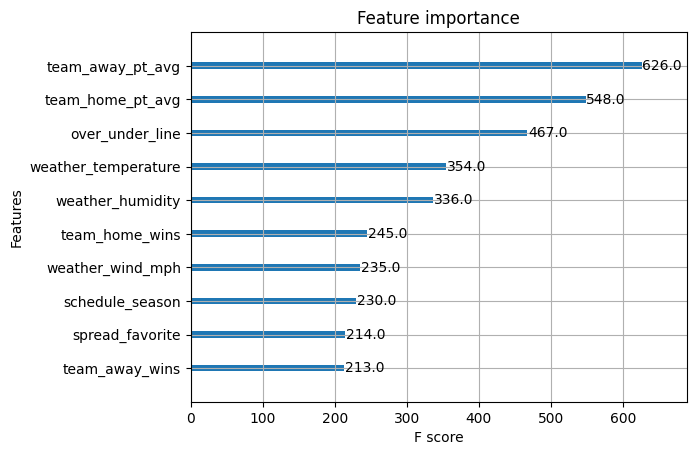

In [33]:
#understanding feature importance
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(best_xgb_model, max_num_features=10)
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

probabilities = best_xgb_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, probabilities)

print("AUC-ROC Score:", auc_roc)


AUC-ROC Score: 0.6936939512108242


In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.6177105831533477
Recall: 0.6143931256713212
F1-score: 0.6160473882606354


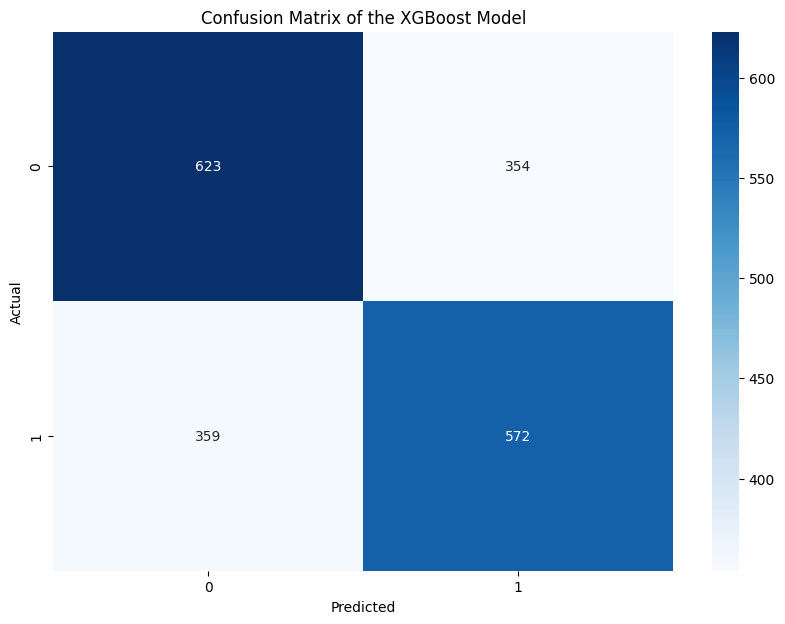

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# You've already calculated the confusion matrix in the previous script
conf_matrix = conf_matrix

# Set up the matplotlib figure
plt.figure(figsize=(10,7))

# Generate a heatmap in seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Give the plot a title
plt.title('Confusion Matrix of the XGBoost Model')

# Display the plot
plt.show()



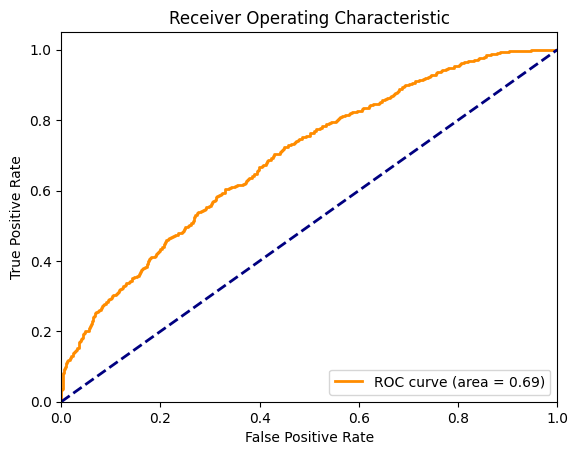

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities with the predict_proba method
y_score = best_xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()




In [44]:
import sklearn
print(sklearn.__version__)


1.2.2
